**Universidade Estadual de Campinas - Unicamp**

**Faculdade de Tecnologia - FT**

**Autor:** Ulisses Martins Dias

**Disciplina:** TT003 - Tópicos em Computação e Informática III

**Aula 11:** Monte Carlo com Jogo da Velha e Redes Neurais

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ulissesdias/tt003/blob/main/notebooks/aula12_monte_carlo_com_jogo_da_velha_e_redes_neurais.ipynb)

# Monte Carlo com Jogo da Velha

Em aulas anteriores, vimos o Monte Carlo sendo usado para criar um jogador mais inteligente para o jogo da velha. Entretanto, esse jogador colocava todos os *state-values* na memória, o que pode ser um problema no caso de muitos estados.

Uma solução seria tentar usar uma rede neural para nos dizer os valores dos *state-values*. Se isso for possível, teremos uma rede-neural como oráculo, que será capaz de nos dizer qual a melhor jogada a realizar!

Vamos começar redefinindo os *rewards* para treinar o nosso jogo.

In [1]:
## Efetuando o download do código da biblioteca
!wget https://raw.githubusercontent.com/ulissesdias/tt003/main/libraries/tic_tac_toe.py

## Importando a biblioteca
import tic_tac_toe as ttt

--2023-11-29 17:20:02--  https://raw.githubusercontent.com/ulissesdias/tt003/main/libraries/tic_tac_toe.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674 (3.6K) [text/plain]
Saving to: ‘tic_tac_toe.py’

tic_tac_toe.py      100%[===================>]   3.59K  --.-KB/s    in 0s      

2023-11-29 17:20:02 (52.0 MB/s) - ‘tic_tac_toe.py’ saved [3674/3674]



In [2]:
def rewards(tab) :
    lwinner = ttt.winner(tab)
    if lwinner == 0 :
        return -1
    elif lwinner == 1 :
        return 10
    else :
       return -10

In [3]:
## Jogo inconcluso
rewards((-1,0,0,1,0,1,-1,0,0))

-1

In [4]:
## Vitória das brancas
rewards((1,0,-1, 1,-1,0,  1,0,0))

10

## Rede Neural do Jogador com Política

A inteligência do jogador depende exclusivamente da política e esta depende exclusivamente de quão bem calculados são os state-values. Como Monte Carlo pode ser usado para resolver o processo de **evaluation**, podemos melhorar a política com os novos **state-values**.  Isso foi o que aprendemos na aula passada.

Agora temos que imaginar que os nossos state-values serão mantidos por uma rede neural. Para tanto, vamos começar analisando essa rede:

In [5]:
import torch
import torch.nn as nn ## Pacote para adicionar camadas de Redes Neurais

In [6]:
class TicTacToeNet(nn.Module):
    def __init__(self):
        super(TicTacToeNet, self).__init__()
        self.input_layer    = nn.Linear(9,128)
        self.hidden_layer1  = nn.Linear(128,64)
        self.output_layer   = nn.Linear(64,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.output_layer(out)
        return out


Instanciaremos agora a nossa rede neural. Essa rede ficará na memória como variável global para ser usada outras vezes.

In [7]:
## Os state_values serão uma variável global neste notebook. Nele
## estará contido tudo aquilo que o agente precisa para fazer uma boa
## jogada
state_values_net = TicTacToeNet()

Vamos agora olhar as modificações no Aprendizado por Reforço.

Observe que os nossos *state_valeus* são uma instância da rede neural. Nesse caso, devemos mudar o nosso código para que atenda esse quesito. Observe que as mudanças não são tão grandes assim. Temos apenas que obter uma predição da rede quando quisermos os *state_values*.

In [8]:
import random

## Para computação dos state_values, usaremos gamma = 0.7 para
## descontos futuros
gamma = 0.7

def player_rl(tab, turn, epsilon = 0) :
    ## A maioria do código é semelhante o da aula passada.
    valid_moves = ttt.get_valid_moves(tab)

    epsilon_random = random.random()
    if epsilon_random < epsilon :
      return turn, random.choice(valid_moves)
    else :
      scores = []
      for move in valid_moves :
        next_state = list(tab)
        next_state[move] = turn
        ####################################################################
        ## A linha abaixo é a única coisa que mudou.
        ####################################################################
        scores.append(rewards(tuple(next_state)) + gamma*state_values_net(torch.tensor(next_state,  dtype =  torch.float)).item())

      best_score = None
      if (turn == 1) :
          best_score = max(scores)
      else :
          best_score = min(scores)

      best_moves = []
      for i in range(len(scores)) :
        if scores[i] == best_score :
          best_moves.append(valid_moves[i])

      return turn, random.choice(best_moves)

# Monte Carlo

Na hora de atualizar os valores que correspondem à inteligência do jogador, precisamos entender que estamos atualizando os pesos de uma rede neural. Vamos configurar os hiperparâmetros da rede. Nada especial aqui, estamos configurando da mesma forma como configuramos para o banco de dados **iris** em aulas anteriores, exceto para a função de custo, dado que aqui temos um problema de regressão.

In [9]:
## Hiperparâmetros: note que tudo o que temos abaixo pode ser melhorado.
learning_rate = 0.01 # Taxa de aprendizado
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(state_values_net.parameters(),lr=learning_rate)

batch_size = 16
epochs = 20 ## Não exagere aqui, nosso código não é otimizado

A seguir criamos uma função para realizar o treinamento. Nada muito diferente do que já aprendemos na disciplina.

In [10]:
def train_network(x_train, y_train) :
    batch_no = len(x_train) // batch_size

    for epoch in range(epochs):

        ## Criando os MiniBatches
        for i in range(batch_no):

            start = i * batch_size
            end = start + batch_size

            x_var = x_train[start:end]
            y_var = y_train[start:end]

            # Limpando os gradientes do último uso de loss.backward()
            optimizer.zero_grad()

            # Passo "forward"
            output_train = state_values_net(x_var)

            # Computando a loss
            loss = loss_fn(output_train, y_var)

            # backward: calculando os gradientes
            loss.backward()

            # Optimizando os pesos com o gradiente computado
            optimizer.step()

Vejamos alguns resultados antes do treino

In [11]:
## Vitória das brancas no próximo lance
state_values_net(torch.tensor([-1,0,0,1,0,1,-1,0,0], dtype = torch.float))

tensor([0.1234], grad_fn=<ViewBackward0>)

In [12]:
## Vitória das pretas no próximo lance
state_values_net(torch.tensor([-1,-1,0,1,0,1,1,0,0], dtype = torch.float))

tensor([0.1308], grad_fn=<ViewBackward0>)

Finalmente, vamos começar a atualizar a rede neural. Faremos primeiramente uma inicialização com jogos ao acaso para seguir a metodologia padrão. O modo como inicializaremos é simples:

1. Geraremos um número de episódios.
2. Computaremos a soma dos retornos descontados para cada estado alcançado nestes episódios e salvaremos em memória.
3. Transformaremos esses retornos em tensores.
4. Treinaremos a rede.

O passo 2 é igual à função **update_state_values_monte_carlo** que tínhamos na aula anterior. Entretanto, ao invés de atualizar os **state_values**, salvaremos em memória algumas poucas instâncias para treinar a rede. Veja a função a seguir:

In [13]:
## Código de aulas anteriores
def update_state_values_monte_carlo(rewards, state_values_dict, amostra, gamma = 0.7, alpha = 0.1) :
    discounted_return = 0
    next_state        = amostra[-1]

    for state in reversed(amostra[:-1]) :
        discounted_return = gamma*discounted_return + rewards(next_state)

        state_values_dict[state] = state_values_dict.get(state,0) + alpha*(discounted_return - state_values_dict.get(state, 0))
        next_state = state


Vamos exemplificar os quatros passos a seguir. Como a rede ainda não tem conhecimento de nada, vamos colocar epsilon = 1 no jogador.

In [14]:
# 1. Geraremos um número de episódios.
# 2. Computaremos a soma dos retornos descontados para cada estado alcançado nestes episódios.
state_values_dict = {}
for i in range(100) :
    _, amostra = ttt.game(player_rl, player_rl, epsilon = 1)
    update_state_values_monte_carlo(rewards, state_values_dict, amostra, gamma = 0.7, alpha = 0.1)


# 3. Transformaremos esses retornos em tensores.
x_train = torch.tensor(list(state_values_dict.keys()),   dtype = torch.float)
y_train = torch.tensor(list(state_values_dict.values()), dtype = torch.float)
y_train = torch.unsqueeze(y_train, -1)

# 4. Treinaremos a rede.
train_network(x_train, y_train)

Vejamos alguns resultados da rede após essa  inicialização.

In [15]:
## Vitória das brancas no próximo lance
state_values_net(torch.tensor([-1,0,0,1,0,1,-1,0,0], dtype = torch.float))

tensor([-0.6430], grad_fn=<ViewBackward0>)

In [16]:
## Vitória das pretas no próximo lance
state_values_net(torch.tensor([-1,-1,0,1,0,1,1,0,0], dtype = torch.float))

tensor([-0.7857], grad_fn=<ViewBackward0>)

Verifique agora que os tabuleiros possuem **state_values** mais condizentes com a realidade.

## Efetuando Aprendizado

Agora que temos uma rede inicializada, podemos usar ela mesma para obter os valores de estado atuais antes de gerar os valores de estado futuros. O que precisamos fazer agora é o seguinte:

1. Colocar o agente que usa como inteligência a rede neural para jogar contra si mesmo algumas vezes. Isso gerará episódios que nos darão novos retornos descontados acumulados.
2. Os novos retornos descontados acumulados devem ser salvos na memória. Podemos usar um dicionário para isso.
3. Transformamos esses retornos em tensores.
4. Treinamos a rede com eles.

Devemos lembrar que a rede neural agora contém os valores de estado. Nesse caso, a função  **update_state_values_monte_carlo** deve dar espaço para uma nova implementação em que é feita uma busca pelo valor de estado na rede.

In [17]:
## Código de aulas anteriores
def update_state_values_monte_carlo_neural_network(rewards,
                                                   state_values_dict,
                                                   state_values_net,
                                                   amostra,
                                                   gamma = 0.7,
                                                   alpha = 0.1) :
    discounted_return = 0
    next_state        = amostra[-1]

    for state in reversed(amostra[:-1]) :
        discounted_return = gamma*discounted_return + rewards(next_state)

        ## Obtendo os valores de estado. Se não estiver no dicionário,
        ## então procurar na rede neural.
        previous_state_value = None
        if (state in state_values_dict) :
            previous_state_value = state_values_dict[state]
        else :
            previous_state_value = state_values_net(torch.tensor(state,  dtype = torch.float))

        state_values_dict[state] = previous_state_value + alpha*(discounted_return - previous_state_value)
        next_state = state


Agora vamos efetuar os quatro passos acima mencionados em um laço. Sempre fazendo o jogador jogar contra si mesmo.

In [18]:
ITERACOES = 100 ## Não exagere aqui, nosso código não é otimizado
for i in range(ITERACOES) :
    epsilon = max(0.1, (ITERACOES - i)/ITERACOES)

    if (i % (ITERACOES/10) == 0) :
        print("ITERAÇÃO %i" % i)

    # 1. Geraremos um número de episódios.
    # 2. Computaremos a soma dos retornos descontados para cada estado alcançado nestes episódios.
    state_values_dict = {}
    for i in range(100) :
        _, amostra = ttt.game(player_rl, player_rl, epsilon = 1)
        update_state_values_monte_carlo_neural_network(rewards, state_values_dict,
                                                       state_values_net,
                                                       amostra, gamma = 0.7, alpha = 0.1)

    # 3. Transformaremos esses retornos em tensores.
    x_train = torch.tensor(list(state_values_dict.keys()),   dtype = torch.float)
    y_train = torch.tensor(list(state_values_dict.values()), dtype = torch.float)
    y_train = torch.unsqueeze(y_train, -1)


    # 4. Treinaremos a rede.
    train_network(x_train, y_train)


ITERAÇÃO 1
ITERAÇÃO 2
ITERAÇÃO 3
ITERAÇÃO 4
ITERAÇÃO 5
ITERAÇÃO 6
ITERAÇÃO 7
ITERAÇÃO 8
ITERAÇÃO 9
ITERAÇÃO 11
ITERAÇÃO 12
ITERAÇÃO 13
ITERAÇÃO 14
ITERAÇÃO 15
ITERAÇÃO 16
ITERAÇÃO 17
ITERAÇÃO 18
ITERAÇÃO 19
ITERAÇÃO 21
ITERAÇÃO 22
ITERAÇÃO 23
ITERAÇÃO 24
ITERAÇÃO 25
ITERAÇÃO 26
ITERAÇÃO 27
ITERAÇÃO 28
ITERAÇÃO 29
ITERAÇÃO 31
ITERAÇÃO 32
ITERAÇÃO 33
ITERAÇÃO 34
ITERAÇÃO 35
ITERAÇÃO 36
ITERAÇÃO 37
ITERAÇÃO 38
ITERAÇÃO 39
ITERAÇÃO 41
ITERAÇÃO 42
ITERAÇÃO 43
ITERAÇÃO 44
ITERAÇÃO 45
ITERAÇÃO 46
ITERAÇÃO 47
ITERAÇÃO 48
ITERAÇÃO 49
ITERAÇÃO 51
ITERAÇÃO 52
ITERAÇÃO 53
ITERAÇÃO 54
ITERAÇÃO 55
ITERAÇÃO 56
ITERAÇÃO 57
ITERAÇÃO 58
ITERAÇÃO 59
ITERAÇÃO 61
ITERAÇÃO 62
ITERAÇÃO 63
ITERAÇÃO 64
ITERAÇÃO 65
ITERAÇÃO 66
ITERAÇÃO 67
ITERAÇÃO 68
ITERAÇÃO 69
ITERAÇÃO 71
ITERAÇÃO 72
ITERAÇÃO 73
ITERAÇÃO 74
ITERAÇÃO 75
ITERAÇÃO 76
ITERAÇÃO 77
ITERAÇÃO 78
ITERAÇÃO 79
ITERAÇÃO 81
ITERAÇÃO 82
ITERAÇÃO 83
ITERAÇÃO 84
ITERAÇÃO 85
ITERAÇÃO 86
ITERAÇÃO 87
ITERAÇÃO 88
ITERAÇÃO 89
ITERAÇÃO 91
ITERAÇÃO 92
ITERAÇÃO 93
I

Verifique agora que os tabuleiros possuem **state_values** mais condizentes com a realidade.

In [19]:
## Vitória das brancas no próximo lance
state_values_net(torch.tensor([-1,0,0,1,0,1,-1,0,0], dtype = torch.float))

tensor([0.1875], grad_fn=<ViewBackward0>)

In [20]:
## Vitória das pretas no próximo lance
state_values_net(torch.tensor([-1,-1,0,1,0,1,1,0,0], dtype = torch.float))

tensor([-3.9969], grad_fn=<ViewBackward0>)

## Validando Resultados

Vamos agora colocar o possante jogador contra alguém ao acaso.

In [21]:
def campeonato(player1, player2, num_games = 1000) :
    results = [0,0,0]
    for i in range(num_games) :
        result, x = ttt.game(player1, player2)
        results[result] += 1
    return tuple(results)

In [22]:
results = campeonato(ttt.random_player, player_rl)
print("Draw = %i, Acaso = %i, RL = %i" % results)

results = campeonato(player_rl, ttt.random_player)
print("Draw = %i, RL = %i, Acaso = %i" % results)

Draw = 97, Acaso = 52, RL = 851
Draw = 21, RL = 949, Acaso = 30


O jogador ficou melhor do que era antes? A distribuição de vitórias e derrotas é melhor do que o jogador ao acaso?

# Desafiando Humanos

Que tal agora desafiar um humano? Vamos gerar um código que torne isso possível, não faremos nada muito mirabolante, apenas trocaremos as chamadas de **print** para **display(board)**.


In [23]:
def human_player(tab, turn) :
    valids  = ttt.get_valid_moves(tab)
    print(valids)

    board = ttt.draw_board( tab )
    display(board)
    move = int(input())

    while not move in valids :
        move = int(input())
    return turn, move

[0, 1, 2, 3, 5, 6, 7, 8]


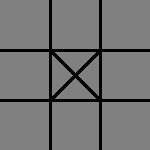

1
[0, 2, 3, 5, 7, 8]


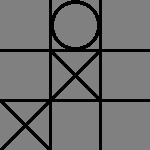

2
[0, 3, 5, 8]


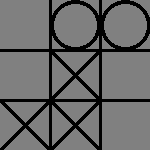

0


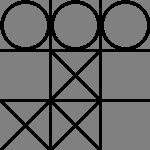

In [24]:
result, history = ttt.game(player_rl, human_player)
ttt.draw_board(history[-1])

In [25]:
images = ttt.generate_image_history(history)
ttt.display_sequence(images)

interactive(children=(IntSlider(value=2, description='frame', max=5), Output()), _dom_classes=('widget-interac…

<function tic_tac_toe.display_sequence.<locals>._show(frame=(0, 5))>